In [102]:
import xml.etree.ElementTree as ET
import os
import numpy as np
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToPILImage
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from random import randint

In [103]:
class_mapping = {
    'person': 0,
    'bird': 1,
    'cat': 2,
    'cow': 3,
    'dog': 4,
    'horse': 5,
    'sheep': 6,
    'aeroplane': 7,
    'plane': 7,
    'bike': 8,
    'bicycle':8,
    'boat': 9,
    'bus': 10,
    'car': 11,
    'motorbike': 12,
    'train': 13,
    'bottle': 14,
    'chair': 15,
    'diningtable': 16,
    'table':16,
    'pottedplant': 17,
    'plant': 17,
    'sofa': 18,
    'tvmonitor': 19,
    'monitor': 19,
    'background': 20,
    'void': 255
}

In [104]:
def read_scribble_xml(xml_file):
    #  Parse XML into Element Tree
    tree = ET.parse(xml_file)
    root = tree.getroot()

    #  Read meta data
    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    #  Read all points and assign them to the tensor
    tensor_categories = torch.zeros((22, 224, 224))
    
    
    polygons = root.findall('polygon')
    for polygon in polygons:
        tag = polygon.find('tag').text
        points = np.array([(min(int(int(point.find('X').text)/width*224), 223), min(int(int(point.find('Y').text)/height*224),223)) for point in polygon.findall('point')])
        tensor_categories[class_mapping[tag], points[:, 1], points[:, 0]] = 1 
    
    return filename, tensor_categories


In [105]:
# Define dataset
class ScribbleDataset(Dataset):
    def __init__(self, image_dir, xml_dir, xml_files, transform=None):
        self.image_dir = image_dir
        self.xml_files = xml_files
        self.transform = transform
        self.xml_dir = xml_dir

    def __len__(self):
        return len(self.xml_files)

    def __getitem__(self, idx):
        xml_file = self.xml_files[idx]
        xml_path = os.path.join(self.xml_dir, xml_file)
        image_path = os.path.join(self.image_dir, xml_file.replace(".xml", ".jpg"))

        filename, tensor_categories = read_scribble_xml(xml_path)
        image = Image.open(image_path)

        sample = {'filename':filename,'image': image, 'tensor_category': tensor_categories}

        if self.transform:
            sample = self.transform(sample)

        return sample


In [106]:
class ToTensor(object):
    def __call__(self, sample):
        filename, image, tensor_categories = sample['filename'], sample['image'], sample['tensor_category']
        
        # Convert image to tensor
        image = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()])(image)
        
        return {'filename':filename, 'image': image, 'tensor_category': tensor_categories}

In [107]:
# Set up dataset and dataloader
xml_dir = "scribble"
image_dir = "train_JPEGImages"
xml_list = os.listdir(xml_dir)
transform = transforms.Compose([ToTensor()])
train_data, val_data = train_test_split(xml_list, test_size=0.1, random_state=1)
train_dataset = ScribbleDataset(image_dir=image_dir, xml_dir=xml_dir, xml_files=train_data, transform=transform)
val_dataset = ScribbleDataset(image_dir=image_dir, xml_dir=xml_dir, xml_files=val_data, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [108]:
# Define the U-Net model
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        
        resnet18 = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet18.children())[:-2])

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            
            nn.ConvTranspose2d(64, num_classes, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [109]:
class N_Link_Loss(nn.Module):
    def __init__(self):
        super(N_Link_Loss, self).__init__()

    def forward(self, inputs, predication):
        sigma = 0.05
        var_lambda = 100
        #  Calculate link weight over the batch
        n_right_weight = var_lambda*torch.exp(-torch.linalg.norm(torch.roll(inputs, shifts=1, dims=2) - inputs, dim=1) / sigma**2)
        n_below_weight = var_lambda*torch.exp(-torch.linalg.norm(torch.roll(inputs, shifts=1, dims=3) - inputs, dim=1) / sigma**2)

        n_link_weight = n_right_weight + n_below_weight
        
        #  Calculate predication L2 norm over the batch
        n_right_coherence = torch.linalg.norm(torch.roll(predication, shifts=1, dims=2) - predication, dim=1)
        n_below_coherence = torch.linalg.norm(torch.roll(predication, shifts=1, dims=3) - predication, dim=1)
        n_link_coherence = n_right_coherence + n_below_coherence
        
        n_link_loss = (n_link_coherence*n_link_weight).sum()

        return n_link_loss


In [110]:
class PairwiseRegularizationLoss(nn.Module):
    def __init__(self):
        super(PairwiseRegularizationLoss, self).__init__()

    def forward(self, input_img, output_img):
        # Ensure input and output have the same spatial dimensions
        assert input_img.shape[2:] == output_img.shape[2:], "Input and output images must have the same spatial dimensions"
        var_lambda = 1
        sigma_sqr = 0.0025
        # Calculate pairwise differences for input and output images
        right_diff_input = torch.roll(input_img, shifts=1, dims=3) - input_img
        below_diff_input = torch.roll(input_img, shifts=1, dims=2) - input_img

        right_diff_output = torch.roll(output_img, shifts=-1, dims=3) - output_img
        below_diff_output = torch.roll(output_img, shifts=-1, dims=2) - output_img

        # Calculate L2 norms
        right_norm_input = var_lambda* torch.exp(-1*torch.linalg.norm(right_diff_input, dim=1)/(2*sigma_sqr))
        below_norm_input = var_lambda* torch.exp(-1*torch.linalg.norm(below_diff_input, dim=1)/(2*sigma_sqr))

        right_norm_output = torch.linalg.norm(right_diff_output, dim=1)
        below_norm_output = torch.linalg.norm(below_diff_output, dim=1)

        # Calculate weighted loss
        loss = ((right_norm_output * right_norm_input) + (below_norm_output * below_norm_input)).mean()

        return loss

In [111]:
# Initialize U-Net model
in_channels = 3
out_channels = 22  # Number of classes
model_UNet = UNet(out_channels)
num_epochs = 4

# Define loss function and optimizer
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = N_Link_Loss()
criterion_3 = PairwiseRegularizationLoss()
optimizer = optim.Adam(model_UNet.parameters(), lr=0.001)

# Set device (GPU if available, otherwise CPU)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(device)
model_UNet.to(device)

cuda


UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [112]:
# Train function for image dataset
def train_image(model, dataloader, optimizer, device):
    model.train()
    num_batches = len(dataloader)
    train_loss = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images, targets = batch['image'].to(device), batch['tensor_category'].to(device)
        # Forward pass
        outputs = model(images)
        # Compute your loss based on the weak annotations
        loss = criterion_1(outputs, targets) + criterion_3(images, outputs)
        train_loss += loss.item()
        #print(criterion_1(outputs, targets).item())
        #print(criterion_3(outputs, targets).item())
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_train_loss = train_loss / num_batches
    return average_train_loss

In [113]:
# Test function for image dataset
def test_image(model, dataloader, device):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, targets = batch['image'].to(device), batch['tensor_category'].to(device)
            outputs = model(images)
            
            loss = criterion_1(outputs, targets) + criterion_3(images, outputs)
            test_loss += loss.item()

    average_test_loss = test_loss / num_batches
    return average_test_loss

In [114]:
# Training loop
for epoch in range(num_epochs):
    train_loss = train_image(model_UNet, train_dataloader, optimizer, device)
    validation_loss = test_image(model_UNet, val_dataloader, device)

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {validation_loss:.4f}")

# Save or use the trained model for inference
torch.save(model_UNet.state_dict(), 'seeds_weakly_supervised_segmentation_model.pth')

Epoch 1/4: 100%|██████████| 76/76 [00:22<00:00,  3.32it/s]


Epoch [1/4]
Train Loss: 0.0404
Validation Loss: 0.0259


Epoch 2/4: 100%|██████████| 76/76 [00:22<00:00,  3.45it/s]


Epoch [2/4]
Train Loss: 0.0259
Validation Loss: 0.0233


Epoch 3/4: 100%|██████████| 76/76 [00:21<00:00,  3.51it/s]


Epoch [3/4]
Train Loss: 0.0232
Validation Loss: 0.0230


Epoch 4/4: 100%|██████████| 76/76 [00:21<00:00,  3.47it/s]

Epoch [4/4]
Train Loss: 0.0214
Validation Loss: 0.0203


In [115]:
color = []
n = 22
color_choice = int(0xFFFFFF/22)
class_list = [i for i in range(1, 22)]
for i in range(n):
    color.append('#%06X' % randint(0, 0xFFFFFF))
distinct_colors = list(mcolors.TABLEAU_COLORS)[:22]
cmap = mcolors.LinearSegmentedColormap.from_list(class_list, distinct_colors)

torch.Size([22, 224, 224])
torch.Size([224, 224])


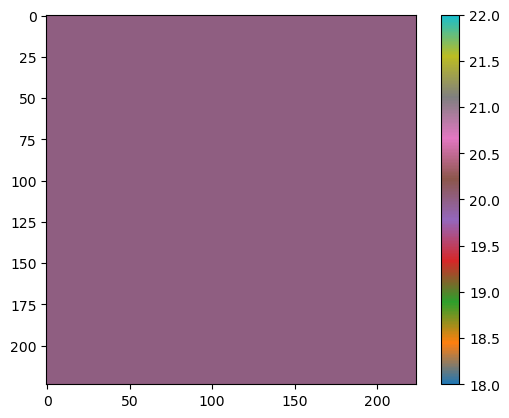

In [120]:
model_UNet.eval()
image_number = 600
tensor = model_UNet(val_dataset[image_number]['image'].to(device).unsqueeze(0)).squeeze(0)
normalized_tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
print(normalized_tensor.shape)
predicted_classes = torch.argmax(tensor, dim=0)
print(predicted_classes.shape)
plt.imshow(predicted_classes.cpu(), cmap=cmap)

#plt.imshow(val_dataset[3]['image'].permute(1, 2, 0).numpy())
plt.colorbar()
plt.show()

In [117]:
import pandas as pd    
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 100)

2009_002611.jpg


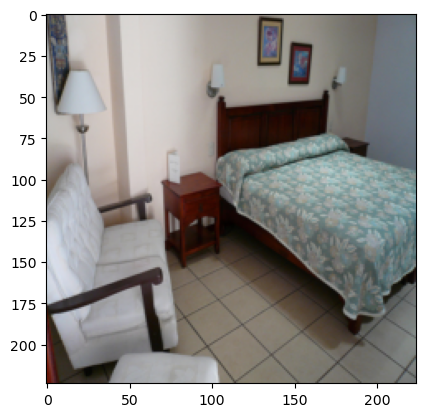

In [121]:
plt.imshow(val_dataset[image_number]['image'].permute(1, 2, 0).numpy())
print(val_dataset[image_number]['filename'])
#print(val_dataset[3]['tensor_category'])